# Hough Transform
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maxima in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough transform.

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.transform import hough_line, hough_line_peaks
import cv2
%matplotlib inline

## Open Image
UFPR.jpg <br>
lines.png <br>
wave.jpg 

(708, 1280)


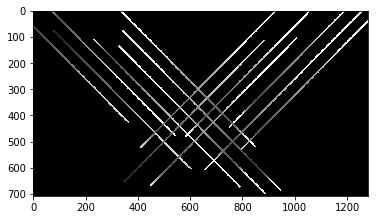

In [2]:
im_gray = cv2.imread('imgs/lines.png',cv2.IMREAD_GRAYSCALE)
print(im_gray.shape)
plt.imshow(im_gray,cmap='gray')

## Gradient Image

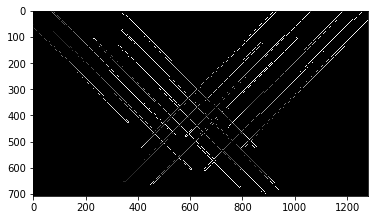

In [3]:
im_grad = gradient(im_gray, disk(1))
plt.imshow(im_grad,cmap='gray')

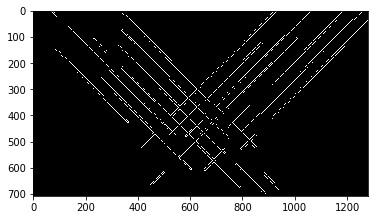

In [4]:
# Otsu's thresholding 
ret3,im_bin = cv2.threshold(im_grad,0,255,cv2.THRESH_OTSU)
plt.imshow(im_bin,cmap='gray')

## Hough Transform
$r = xcos(\theta)+ysin(\theta)$ <br>
$r \in \left[-\sqrt{M^2+N^2},\sqrt{M^2+N^2}\right]$<br>
$\theta \in \left[ -\dfrac{\pi}{2},\dfrac{\pi}{2}\right]$ <br>

In [5]:
y_max, x_max = im_bin.shape

r_max = np.sqrt(y_max**2+x_max**2)
r_min = -r_max
r_steps = np.ceil(r_max-r_min).astype('int')
r_step = (r_max-r_min)/(r_steps-1)
r_list = np.arange(r_min,r_max+r_step,r_step)
if r_list.shape[0]!=r_steps:
    r_list = r_list[:-1]

o_steps = 2000
o_max = -np.pi/2
o_min = -o_max
o_step = (o_max-o_min)/(o_steps-1)
o_list = np.arange(o_min,o_max+o_step,o_step)
if o_list.shape[0]!=o_steps:
    o_list = o_list[:-1]

r_steps,o_list.shape

(2926, (2000,))

In [6]:
%%time
im_hough = np.zeros((r_steps,o_steps))
for y in range(im_bin.shape[0]):
    for x in range(im_bin.shape[1]):
        if im_bin[y,x]:
            r_o_list = x*np.cos(o_list)+y*np.sin(o_list)
            r = np.round((r_o_list-r_min)/r_step).astype('int')
            im_hough[r,range(o_steps)]+=1
            

CPU times: user 7.77 s, sys: 38.2 ms, total: 7.81 s
Wall time: 7.81 s


(2926, 2000)


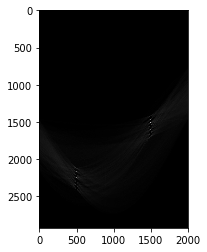

In [7]:
print(im_hough.shape)
plt.imshow(im_hough,cmap='gray')

## Plot lines

In [8]:
def plot_lines(im_gray,dists,angles,linewidth=0.7):
    pts1 = np.around(dists/np.sin(angles))                        #x=0     => [0,r/sin(o)]
    pts2 = np.around((dists-x_max*np.cos(angles))/np.sin(angles)) #x=x_max => [x_max,(r-x_max.cos(o))/sin(o)]
    
    #plot img
    plt.figure(figsize=(10,10))
    plt.imshow(im_gray, cmap='gray')
    
    #plot lines
    for pt1,pt2 in zip(pts1,pts2):
        #plt.plot(x,y)
        plt.plot((0, x_max), (pt1, pt2), 'r',linewidth=linewidth)

    # [xmin, xmax, ymin, ymax]
    plt.axis((0,x_max,y_max,0))
    
    plt.show()

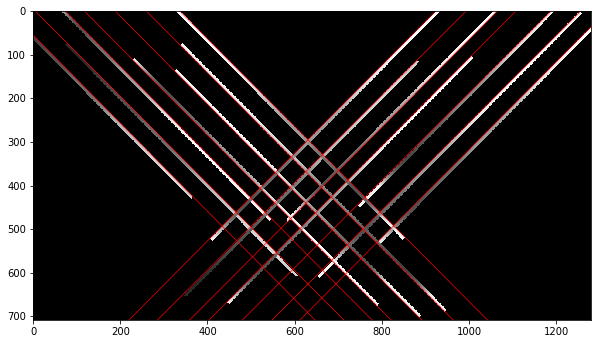

In [9]:
_, angles, dists = hough_line_peaks(im_hough, o_list, r_list)
plot_lines(im_gray,dists,angles)

## Skimage

CPU times: user 487 ms, sys: 86.3 ms, total: 574 ms
Wall time: 474 ms


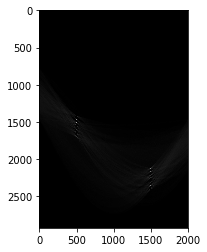

In [10]:
%%time
h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/2000))
plt.imshow(h,cmap='gray')

('Peaks or Lines:', 14)


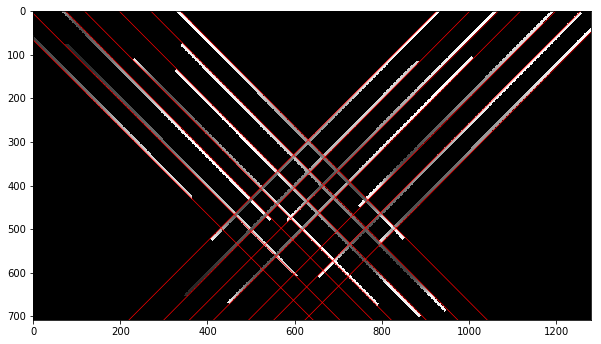

In [11]:
_, angles, dists = hough_line_peaks(h, theta, d)
print('Peaks or Lines:',len(angles))
plot_lines(im_gray,dists,angles)

## Find Lines 1
Simple Threshold <br>
Threshold = $\alpha(max-min)$

In [12]:
def hough_peaks1(im_hough, o_list, r_list, alpha=0.5):
    
    #mask create
    threshold = (im_hough.max()-im_hough.min())*alpha
    mask_peaks = im_hough>threshold
    
    #find all lines
    angles = list()
    dists = list()
    peaks = list()
    for r in range(mask_peaks.shape[0]):
        for o in range(mask_peaks.shape[1]):
            if mask_peaks[r][o]:
                angles.append(o_list[o])
                dists.append(r_list[r])
                peaks.append(im_hough[r][o])
    
    #to numpy
    angles = np.array(angles)
    dists = np.array(dists) 
    peaks = np.array(peaks) 
    
    print('Threshold:',threshold,'Peaks or Lines:',len(peaks))
    
    return peaks,angles,dists

('Threshold:', 363.0, 'Peaks or Lines:', 129)


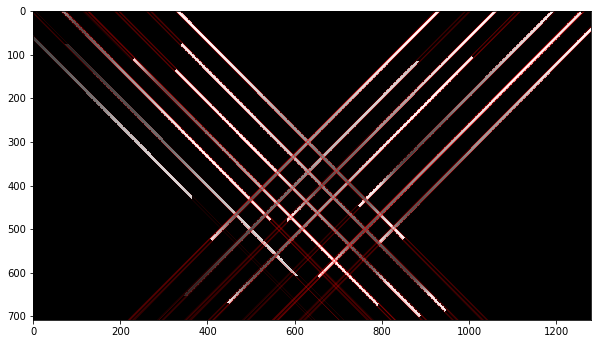

CPU times: user 1.95 s, sys: 351 ms, total: 2.3 s
Wall time: 1.86 s


In [13]:
%%time
_,angles,dists = hough_peaks1(im_hough, o_list, r_list)
plot_lines(im_gray,dists,angles,0.1)

## Find Lines 2
Simple Threshold <br>
$\downarrow$  <br>
Graph by Euclidean Distances of the peaks <br>
$\downarrow$  <br>
Component Connection <br>
$\downarrow$  <br>
Lines by weighted arithmetic mean 

In [14]:
alpha = 0.4 # Threshold [0,1[
beta = 2 #maximum distance of connected peaks (in pixels)

In [15]:
peaks,angles,dists = hough_peaks1(im_hough, o_list, r_list,alpha=alpha)

('Threshold:', 290.40000000000003, 'Peaks or Lines:', 235)


### My codes:

In [16]:
from collections import deque

#### Create Graph by Euclidean Distances
adjacency lists

In [17]:
%%time

adjacency_lists = list()

for i in xrange(len(peaks)):
    #Euclidean distances between point i and all points before i
    x1 = angles[i]
    x2 = angles#[i+1:]
    y1 = dists[i]
    y2 = dists#[i+1:]
    euclid_dist = (x2-x1)**2+(y2-y1)**2
    # very slow function
    #euclid_dist = euclidean_distances([[x1,y1]],zip(x2,y2))[0]
    
    #find edges
    edges = euclid_dist<(beta**2)
    edges = np.arange(edges.shape[0])[edges]
    #edges += i+1
    #edges = [(i,j) for j in edges]

    #save edges
    adjacency_lists.append(edges.astype('int32'))
    #edges_list = np.append(edges_list,np.array(edges))
    #edges_list += list(edges)

    #print
    if i%10000==0:
        print(i,'/',len(peaks))

print("to numpy ...")
adjacency_lists = np.array(adjacency_lists)
print(adjacency_lists.shape)

(0, '/', 235)
to numpy ...
(235,)
CPU times: user 6.55 ms, sys: 0 ns, total: 6.55 ms
Wall time: 5.62 ms


__Component Connection:__

In [18]:
%%time

visited = np.zeros(len(peaks))
n_class = 0

for v in xrange(len(peaks)):
    if visited[v]:
        continue
    
    #new class or component
    n_class += 1
    visited[v] = n_class
    
    #stack of vertices to look
    stack = deque()
    stack.append(v)
    
    while stack:
        #new vertice
        v = stack.pop()
        
        #add all neighbors not visited
        for neighbor in adjacency_lists[v]:
            
            if not visited[neighbor]:
                stack.append(neighbor)
                visited[neighbor] = n_class
                
print(n_class,'class')

(27, 'class')
CPU times: user 997 µs, sys: 215 µs, total: 1.21 ms
Wall time: 848 µs


__Creating Lines:__
weighted arithmetic mean 

In [19]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()

for c in xrange(n_class):
    
    #class mask
    mask = visited==(c+1)
    print(mask.sum(), 'peaks')
    
    #component connection points
    cc_angles = angles[mask]
    cc_dists = dists[mask]
    cc_peaks = peaks[mask]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

(6, 'peaks')
(5, 'peaks')
(8, 'peaks')
(9, 'peaks')
(10, 'peaks')
(9, 'peaks')
(2, 'peaks')
(15, 'peaks')
(17, 'peaks')
(8, 'peaks')
(6, 'peaks')
(8, 'peaks')
(9, 'peaks')
(8, 'peaks')
(9, 'peaks')
(7, 'peaks')
(8, 'peaks')
(9, 'peaks')
(9, 'peaks')
(9, 'peaks')
(10, 'peaks')
(8, 'peaks')
(9, 'peaks')
(11, 'peaks')
(10, 'peaks')
(8, 'peaks')
(8, 'peaks')


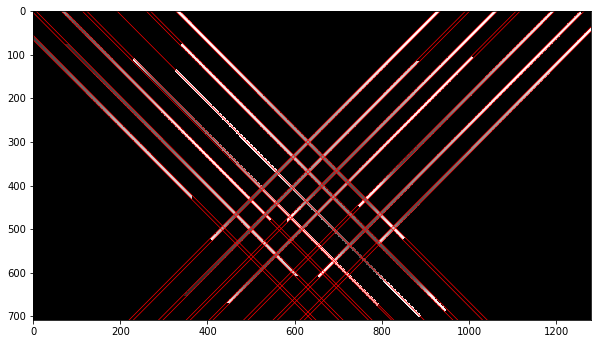

In [20]:
plot_lines(im_gray,avg_dists,avg_angles)

### With Libraries

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx

__Euclidean Distance Matrix:__

In [22]:
pts = np.array(zip(angles,dists))
euclidean_matrix = euclidean_distances(pts)

__Create Graph:__

In [23]:
adj_matrix = euclidean_matrix<beta
G = nx.from_numpy_matrix(adj_matrix)

CPU times: user 184 ms, sys: 19.9 ms, total: 204 ms
Wall time: 169 ms


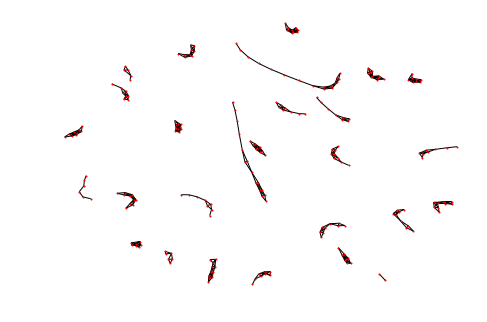

In [24]:
%%time
nx.draw(G,node_size=1)

__Connected Components:__

In [25]:
connected_components = nx.connected_components(G)
connected_components = sorted(nx.connected_components(G), key = len, reverse=True)
len(connected_components)

27

__Creating Lines:__ <br>
weighted arithmetic mean 

In [26]:
avg_angles = list()
avg_dists = list()
avg_peaks = list()
for cc in connected_components:
    
    #points in components
    cc = list(cc)
    cc_angles = angles[cc]
    cc_dists = dists[cc]
    cc_peaks = peaks[cc]
    
    #weighted arithmetic mean 
    angle = np.average(cc_angles, weights=cc_peaks)
    dist = np.average(cc_dists, weights=cc_peaks)
    peak = np.average(cc_peaks)
    
    #save
    avg_angles.append(angle)
    avg_dists.append(dist)
    avg_peaks.append(peak)

#to numpy
avg_angles = np.array(avg_angles)
avg_dists = np.array(avg_dists)
avg_peaks = np.array(avg_peaks)

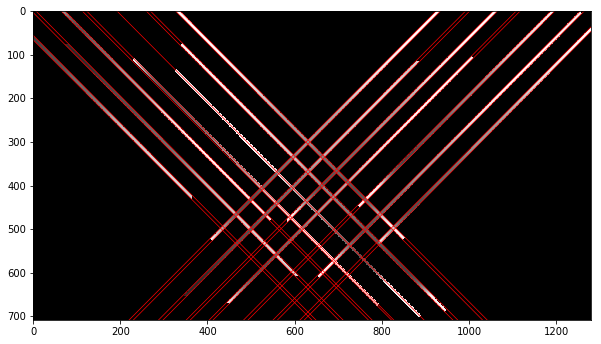

In [27]:
plot_lines(im_gray,avg_dists,avg_angles)